## Import libraries

In [3]:
import psutil
import gc
import os
import pandas as pd
import zipfile
import numpy as np
import nibabel as nib
from io import BytesIO
import matplotlib.pyplot as plt
import nilearn as nil # https://nilearn.github.io/stable/quickstart.html
import time
from nilearn import plotting
from tqdm import tqdm

# from multiprocessing import Pool
# import torch
# from torch.utils import data
# import ants
# from antspynet import brain_extraction
from scipy.ndimage import rotate

import io

## Assign correct directory

In [1]:
# Get the current working directory
print("Current working directory:", os.getcwd())

# Change the working directory to a new path
os.chdir('/scratch/users/neuroimage/conda')

# Check the new working directory
print("New working directory:", os.getcwd())

Current working directory: /accounts/class/s222/neuroimage/scripts
New working directory: /scratch/users/neuroimage/conda


In [ ]:
# def get_brain_data(zip_path, num = None, matrix_only = False):
#   '''
#   Returns a list of lists. Each sub list is a patient, containing the nifti object and numpy array of
#   intensities (x res, y res, slice)

#     Parameters:
#       zip_path (str): Path of zip file containing containing multiple .nifti files 
    
#     Returns:
#       brain_data (list): List of lists of a patients brain volume object and brain volume data intensities
#   '''
#   brain_data = []
#   identifiers = []

#   # https://neurostars.org/t/writing-nibabel-nifti1image-objects-into-bytes-in-memory-instead-of-on-disk/3899/3
#   with zipfile.ZipFile(zip_path, 'r') as zp:
      
#     files = zp.namelist()
#     print(files[0:3])
#     if num is None:
#       num = len(files)

#     for idx, file in enumerate(files[:num]): # if code is taking too long, subsect smaller size
#         identifiers.append(file.split('/')[1])
#         binary_file = zp.open(file, 'r').read()
#         bb = BytesIO(binary_file)
#         fh = nib.FileHolder(fileobj=bb)
        
#         # type nifti object
#         brain_vol = nib.Nifti1Image.from_file_map({'header': fh, 'image': fh})

#         # turns object into numpy array (brain intensities)
#         brain_vol_data = brain_vol.get_fdata()

#         del binary_file
#         if matrix_only:
#           del brain_vol
#           print(brain_vol_data.shape)
#           brain_data.append([brain_vol_data[0, :, :, :]])
#         else:
#           brain_data.append([brain_vol, brain_vol_data])
#         gc.collect()
#         process = psutil.Process()
#         memory_info = process.memory_info()
#         # print(memory_info)
#         if idx % 10 == 0:
#           print(f"After loading {idx + 1} images, Memory used: {memory_info.rss / 1024 / 1024:.2f} MB")
#         #print(f"Finish reading {idx}")

#   zp.close()
#   if matrix_only:
#     return brain_data, identifiers
#   else:
#     return brain_data


In [ ]:
# parallel reading, too slow

# path = r'/content/drive/MyDrive/Capstone-Project/'
# ROOT_PATH = path
# os.chdir(path)

# def load_single_file(binary_file):
#     # binary_file = zp.open(file, 'r').read()
#     bb = BytesIO(binary_file)
#     fh = nib.FileHolder(fileobj=bb)
    
#     # type nifti object
#     brain_vol = nib.Nifti1Image.from_file_map({'header': fh, 'image': fh})

#     # turns object into numpy array (brain intensities)
#     brain_vol_data = brain_vol.get_fdata()
#     print("finish")
#     return [brain_vol, brain_vol_data]


# def get_brain_data(zip_path, num = None):
#   '''
#   Returns a list of lists. Each sub list is a patient, containing the nifti object and numpy array of intensities (x res, y res, slice)

#     Parameters:
#       zip_path (str): Path of zip file containing containing multiple .nifti files 
    
#     Returns:
#       brain_data (list): List of lists of a patients brain volume object and brain volume data intensities
#   '''
#   brain_data = []
    

#   # https://neurostars.org/t/writing-nibabel-nifti1image-objects-into-bytes-in-memory-instead-of-on-disk/3899/3
#   with zipfile.ZipFile(zip_path, 'r') as zp:
      
#     files = zp.namelist()

#     if num is None:
#       num = len(files)
#     t0 = time.time()
#     binary_file_list = [zp.open(file, 'r').read() for file in files[:num]]
#     print(time.time() - t0)
#     with Pool(4) as p:
#         brain_data = p.map(load_single_file, binary_file_list)
#     print(time.time() - t0)
#     # for file in files[:num]: # if code is taking too long, subsect smaller size
#     #     binary_file = zp.open(file, 'r').read()
#     #     bb = BytesIO(binary_file)
#     #     fh = nib.FileHolder(fileobj=bb)
        
#     #     # type nifti object
#     #     brain_vol = nib.Nifti1Image.from_file_map({'header': fh, 'image': fh})

#     #     # turns object into numpy array (brain intensities)
#     #     brain_vol_data = brain_vol.get_fdata()

#     #     brain_data.append([brain_vol, brain_vol_data])

#   zp.close()
#   return brain_data


## Read Labels

In [ ]:
base_path = os.path.join('/accounts', 'grad', 'khern045', 'NeuroimagingCapstone')

mddf = pd.read_parquet(os.path.join(base_path, 'data', 'adni-data', 'ADNI1_Baseline_3T_cwod.parquet'))
mddf.head(15)

,Img_ID,Subject,Group,Sex,Age,Acq_year,Acq_month,Acq_day,B1 Correction,GradWarp,MPR,MPR-R,N3,Scaled
0,I119721,136_S_0195,MCI,M,80,2006,4,4,0,0,1,0,1,1
1,I34416,127_S_0397,MCI,M,75,2006,6,6,1,1,1,0,1,1
2,I39197,130_S_0505,MCI,M,80,2006,10,18,0,0,1,0,1,1
3,I40657,002_S_0413,CN,F,76,2006,5,19,0,0,1,0,1,1
4,I51981,023_S_0078,MCI,F,76,2006,1,12,1,1,1,0,1,1
5,I63508,116_S_0649,MCI,M,87,2006,9,8,1,1,1,0,1,1
6,I69118,128_S_1148,MCI,F,70,2007,1,16,1,1,1,0,1,1
7,I82518,051_S_1338,MCI,M,84,2007,4,26,1,1,0,1,1,1
8,I90026,023_S_0963,CN,M,73,2006,10,17,1,1,0,1,1,1
9,I118773,018_S_0369,CN,M,76,2006,5,11,0,0,1,0,1,1


In [ ]:
df['Group'] = df['Group'].map({'CN':0, 'MCI':1, 'AD':2})
df.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I122678,031_S_0568,1,F,80,bl,MRI,MPR; GradWarp; N3; Scaled,Processed,2006-06-09,NiFTI,2/15/2023
1,I118854,023_S_0061,0,F,77,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2005-12-20,NiFTI,2/15/2023
2,I119018,023_S_0331,1,F,65,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2006-04-12,NiFTI,2/15/2023
3,I118920,023_S_1190,0,F,77,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2007-01-17,NiFTI,2/15/2023
4,I118862,023_S_0078,1,F,76,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2006-01-12,NiFTI,2/15/2023


## Base Plotting


In [ ]:
base_path = 'data/adni1-data/baseline/'
baseline_zip = 'ADNI1_Baseline_3T.zip'

brain_data = get_brain_data(os.path.join(base_path, baseline_zip), num = 80)

brain_vol, brain_vol_data = brain_data[0]

# image is 240 by 256. There are 160 slices
brain_vol_data.shape

['ADNI/023_S_0061/MPR__GradWarp__B1_Correction__N3__Scaled/2005-12-20_15_54_41.0/I31107/ADNI_023_S_0061_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061130182551088_S10633_I31107.nii', 'ADNI/023_S_0139/MPR__GradWarp__B1_Correction__N3__Scaled/2006-02-06_12_11_27.0/I31313/ADNI_023_S_0139_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061201150450460_S11490_I31313.nii', 'ADNI/023_S_0376/MPR__GradWarp__B1_Correction__N3__Scaled/2006-04-28_12_55_22.0/I31392/ADNI_023_S_0376_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061201170258692_S13786_I31392.nii', 'ADNI/023_S_0388/MPR__GradWarp__B1_Correction__N3__Scaled/2006-05-04_15_27_08.0/I31446/ADNI_023_S_0388_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061203120855584_S14001_I31446.nii', 'ADNI/023_S_0604/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-06-20_09_34_04.0/I31468/ADNI_023_S_0604_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061203124804456_S15677_I31468.nii', 'ADNI/023_S_0613/MPR__GradWarp__B1_Correction__N3__Scal

(240, 256, 160)

'AD:136_S_0299', 'CN:130_S_0886', 'MCI:023_S_0078'

In [ ]:
files = zipfile.ZipFile(os.path.join(base_path, baseline_zip), 'r').namelist() 
print(files[1])


ADNI/023_S_0139/MPR__GradWarp__B1_Correction__N3__Scaled/2006-02-06_12_11_27.0/I31313/ADNI_023_S_0139_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061201150450460_S11490_I31313.nii


In [ ]:
# brain_data[0]
df.loc[df.Subject == '023_S_0061'] # CN Person index 0 
df.loc[df.Subject == '023_S_0376'] # MCI Person index 2
df.loc[df.Subject == '023_S_0139'] # AD Person index 1

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
8,I118972,023_S_0139,2,F,66,bl,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,2006-02-06,NiFTI,2/15/2023


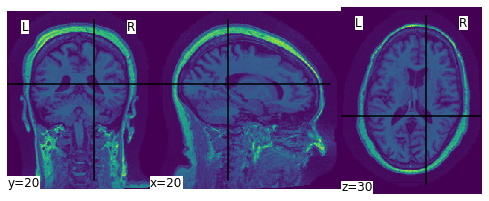

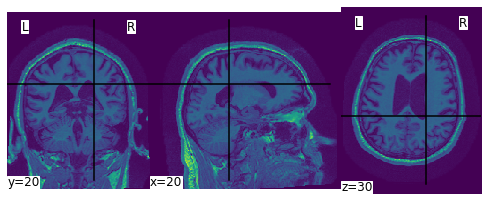

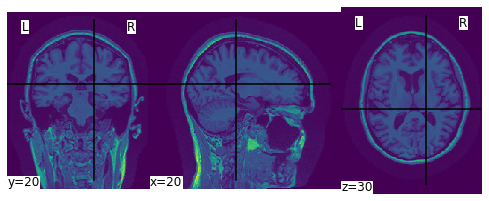

In [ ]:
plotting.plot_img(brain_data[0][0], cut_coords=(20,20,30))
plotting.plot_img(brain_data[2][0], cut_coords=(20,20,30))
plotting.plot_img(brain_data[1][0], cut_coords=(20,20,30))


### Shape Differences

In [ ]:
img_shapes = [brain[1].shape for brain in brain_data]
set(img_shapes)


{(240, 256, 160), (256, 256, 166), (256, 256, 170)}

Out of the 80 images there are 3 unique image dimensions. 
(Height of X pixels, Width of Y pixels, N slices).

We didn't look at all of the images but their could be more unique dimensions. Are these dimensions due to differences in sex, age, stage of cognitive impairment?

Grabbing all subject and image ID's. These will be used as primary/foreign keys to join our data together. 

In [ ]:
files = zipfile.ZipFile(os.path.join(base_path, baseline_zip), 'r').namelist()
# Can change to grab more images files[0:num]
index_list = [1,4]

# grabs the subject number and image ID
img_dirs = [tuple(img_full_path.split('/')[x] for x in index_list) for img_full_path in files[0:80]]

img_dirs[0:5]

[('023_S_0061', 'I31107'),
 ('023_S_0139', 'I31313'),
 ('023_S_0376', 'I31392'),
 ('023_S_0388', 'I31446'),
 ('023_S_0604', 'I31468')]

Combing the keys with the image dimension data

In [ ]:
# image dimension df
imgddf = pd.DataFrame(img_shapes, columns=['Height','Width','Slices'])
# image directory info
imgdi = pd.DataFrame(img_dirs, columns=['Subject','Img_ID'])

imgddf = pd.concat([imgddf, imgdi], axis=1)
imgddf.head()

,Height,Width,Slices,Subject,Img_ID
0,240,256,160,023_S_0061,I31107
1,240,256,160,023_S_0139,I31313
2,240,256,160,023_S_0376,I31392
3,240,256,160,023_S_0388,I31446
4,240,256,160,023_S_0604,I31468


Reading in cleaned data dictionary

In [ ]:
# reading in cleaned data from another file
dfdr = pd.read_parquet(os.path.join(baseline_path, 'ADNI1_Baseline_3T_2_25_2023_clean_wod.parquet'))
dfdr.head()

,Img_ID,Subject,Group,Sex,Age,Acq_year,Acq_month,Acq_day,B1 Correction,GradWarp,MPR,MPR-R,N3,Scaled
0,I122678,031_S_0568,MCI,F,80,2006,6,9,0,1,1,0,1,1
1,I118854,023_S_0061,CN,F,77,2005,12,20,1,1,1,0,1,1
2,I119018,023_S_0331,MCI,F,65,2006,4,12,1,1,1,0,1,1
3,I118920,023_S_1190,CN,F,77,2007,1,17,1,1,1,0,1,1
4,I118862,023_S_0078,MCI,F,76,2006,1,12,1,1,1,0,1,1


Combing dimension info and data dictionary

In [ ]:
# df combined. has the height width and slices information in the data frame
dfcb = pd.merge(dfdr, imgddf, on=['Img_ID', 'Subject'])
# dfcb.head()
print(dfcb.shape)
dfcb.head()

(41, 17)


,Img_ID,Subject,Group,Sex,Age,Acq_year,Acq_month,Acq_day,B1 Correction,GradWarp,MPR,MPR-R,N3,Scaled,Height,Width,Slices
0,I32762,005_S_0602,CN,M,71,2006,7,25,1,1,1,0,1,1,256,256,166
1,I47186,027_S_1082,AD,F,70,2006,12,13,1,1,1,0,1,1,240,256,160
2,I34195,027_S_0404,AD,F,88,2006,5,16,1,1,1,0,1,1,240,256,160
3,I38878,126_S_0605,CN,F,76,2006,6,29,1,1,1,0,1,1,256,256,166
4,I34371,127_S_0260,CN,F,79,2006,5,1,1,1,1,0,1,1,256,256,166


One problem is that we'd only be looking at a small proportion of the data. the data dictionary dataframe is 151 in length and the image info dataframe is 80 in length. Because the image info df has duplicates, it will be cut down.

In [ ]:
dfcb.groupby(['Sex', 'Height', 'Width', 'Slices']).size()

Sex  Height  Width  Slices
F    240     256    160        7
     256     256    166        5
                    170        5
M    240     256    160        8
     256     256    166        6
                    170       10
dtype: int64

My hypothesis about the height and width of the images being different because of sex was wrong. It seems it plays no role. Maybe it's due to different MRI scanners?

In [ ]:
dfcb.groupby(['Acq_year', 'Height', 'Width', 'Slices']).size()

Acq_year  Height  Width  Slices
2005      256     256    170        1
2006      240     256    160        9
          256     256    166       11
                         170       14
2007      240     256    160        6
dtype: int64

In [ ]:
dfcb.groupby(['Group', 'Height', 'Width', 'Slices']).size()

Group  Height  Width  Slices
AD     240     256    160       4
       256     256    166       1
                      170       4
CN     240     256    160       5
       256     256    166       5
                      170       4
MCI    240     256    160       6
       256     256    166       5
                      170       7
dtype: int64

Based on the data we have (n=41), it doesn't seem like the height, width and slice count were based on specific protocols for cognitive decline group. The year group looks like it may have influence on what the height, width and slice protocals were, but its hard to say with so little data points

We could rescale everything. Would that cause image distortion? How to rescale to reduce resolution and distortion?

Can use a resampling function to rescale the images. Use a spline to reduce distortion

In [ ]:
from nibabel.processing import resample_to_output

# Define the target voxel size
target_vox = (1.5,1.5,1.5)

# Resample the image to the target voxel size while preserving the spatial dimensions
# [resample_to_output(brain[0], voxel_sizes=target_vox, order='continuous') for brain in brain_data[0:5]]

## Some Image EDA

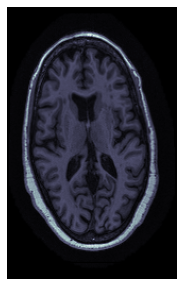

In [ ]:
# basic plotting, not going to use this
fig = plt.figure(figsize=(8,5))
plt.imshow(brain_vol_data[100], cmap='bone')
plt.axis('off')
plt.show()
# plt.savefig("test.png", bbox_inches='tight')

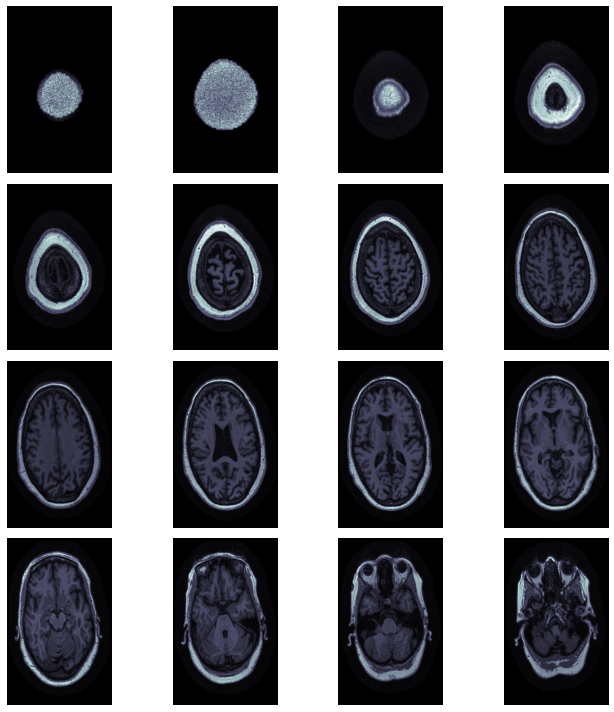

In [ ]:
# not really needed either
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)


fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(brain_vol_data[img], cmap='bone')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

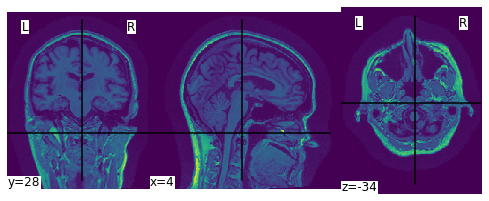

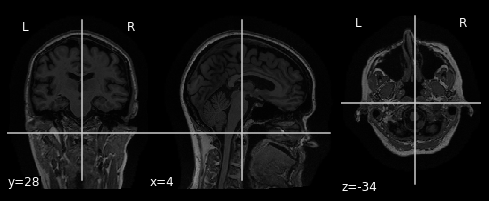

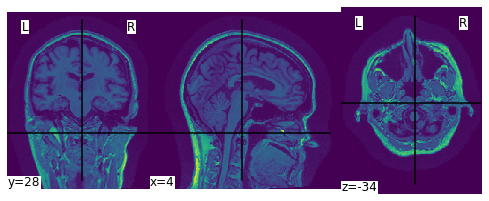

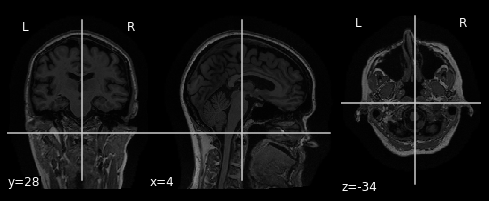

In [ ]:
# supposed to be better way of plotting image
brain_vol, _ = brain_data[1]
plotting.plot_img(brain_vol)
plotting.plot_anat(brain_vol)

brain_vol2, _ = brain_data[2]
plotting.plot_img(brain_vol)
plotting.plot_anat(brain_vol)

### Standardization

In [ ]:
def standardization_norm(image_intensities):
  '''
  Returns a 3D array of z-score normalized intensities

    Parameters:
      image_intensities (np.array): 3D array of image intensities 

    Returns:
      vals (np.array): 3D array of normalized intensities
  '''
  mean = np.mean(image_intensities)
  std = np.std(image_intensities)

  assert std > 0, "Image is blank"
  vals = (image_intensities - mean) / std
  
  return vals


def standardization_0_1(image_intensities):
  '''
  Returns a 3D array of standardized 0 to 1 values

    Parameters:
      image_intensities (np.array): 3D array of image intensities 

    Returns:
      vals (np.array): 3D array of standardized intensities
  '''
  minimum = np.min(image_intensities)
  maximum = np.max(image_intensities)

  vals = (image_intensities - minimum) / (maximum - minimum)
  
  return vals

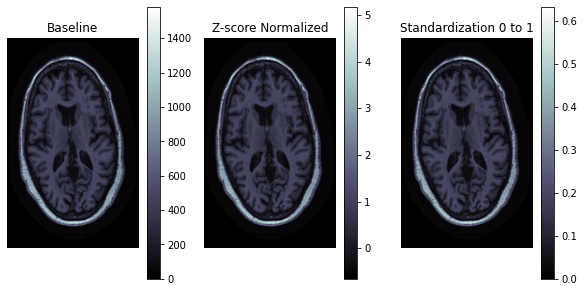

In [ ]:
norm_brain_vol_data = standardization_norm(brain_vol_data)
stand_0_1_brain_vol_data = standardization_0_1(brain_vol_data)

fig, ax = plt.subplots(1,3, figsize=(10,5))
[axi.set_axis_off() for axi in ax.ravel()] # turn off axes

img1 = ax[0].imshow(brain_vol_data[100], cmap='bone')
ax[0].set_title('Baseline')
fig.colorbar(img1, ax=ax[0])

img2 = ax[1].imshow(norm_brain_vol_data[100], cmap='bone')
ax[1].set_title('Z-score Normalized')
fig.colorbar(img2, ax=ax[1])

img3 = ax[2].imshow(stand_0_1_brain_vol_data[100], cmap='bone')
ax[2].set_title('Standardization 0 to 1')
fig.colorbar(img3, ax=ax[2])

plt.show()

# (Data Read-in and) Data augmentation

In [ ]:
# Read in the data again

base_path = 'data/adni1-data/baseline/'
baseline_zip = 'ADNI1_Baseline_3T.zip'

brain_data, files = get_brain_data(os.path.join(base_path, baseline_zip), matrix_only = True, num = 40)

['ADNI/023_S_0061/MPR__GradWarp__B1_Correction__N3__Scaled/2005-12-20_15_54_41.0/I31107/ADNI_023_S_0061_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061130182551088_S10633_I31107.nii', 'ADNI/023_S_0139/MPR__GradWarp__B1_Correction__N3__Scaled/2006-02-06_12_11_27.0/I31313/ADNI_023_S_0139_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061201150450460_S11490_I31313.nii', 'ADNI/023_S_0376/MPR__GradWarp__B1_Correction__N3__Scaled/2006-04-28_12_55_22.0/I31392/ADNI_023_S_0376_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061201170258692_S13786_I31392.nii', 'ADNI/023_S_0388/MPR__GradWarp__B1_Correction__N3__Scaled/2006-05-04_15_27_08.0/I31446/ADNI_023_S_0388_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20061203120855584_S14001_I31446.nii', 'ADNI/023_S_0604/MPR-R__GradWarp__B1_Correction__N3__Scaled/2006-06-20_09_34_04.0/I31468/ADNI_023_S_0604_MR_MPR-R__GradWarp__B1_Correction__N3__Scaled_Br_20061203124804456_S15677_I31468.nii', 'ADNI/023_S_0613/MPR__GradWarp__B1_Correction__N3__Scal

IndexError: ignored

**Data Augmentation**

We are proposing a mix-up method with NC and AD to generate the class of MCI, because the illness is considered as a gradual process. We will generate the weighted mean of matrices of NC and AD as our baseline of MCI. The method is backed up by the two exisiting literature review below. According to Yuji Tokozume and his colleagues (2018), their paper proposed a fresh method of learning for image classification named Between-Class learning (BC learning). This learning approach generates between-class images by randomly blending two images belonging to different classes with a random ratio. The blended image is then used as input for the model, which is trained to produce the mixing ratio. By constraining the shape of feature distributions, BC learning is capable of enhancing the generalization ability. While BC learning was initially intended for sounds that can be digitally mixed, the authors assert that it can also be extended to image data since CNN consider input data as waveforms. In anothetr paper written by Hongyi Zhang and his colleagues (2017), they proposes a new learning principle called mixup to address the undesirable behaviors of large deep neural networks such as memorization and sensitivity to adversarial examples. Mixup trains a neural network on convex combinations of pairs of examples and their labels, which helps regularize the network to favor simple linear behavior in-between training examples. The team conducts experiments on several datasets, including ImageNet-2012, CIFAR-10, CIFAR-100, Google commands, and UCI, which demonstrate that mixup improves the generalization of state-of-the-art neural network architectures. The researchers also discover that mixup reduces the memorization of corrupt labels, increases the robustness to adversarial examples, and stabilizes the training of generative adversarial networks.

In [ ]:
def augment_data(pos, neg, num):
  '''
  generate a few samples by combining positive and nagative samples
  TODO: we can only generate samples through other ways including doing max
  pos: positive_samples
  neg: negative_samples
  num: The num of samples to generate
  return a list of augmented data and a list of labels
  '''
  x_list, y_list = [], []
  pos_len = len(pos)
  neg_len = len(neg)
  for _ in range(num):
    rand_num = np.random.uniform()
    rand_pos, rand_neg = np.random.randint(pos_len), np.random.randint(neg_len)
    x_list.append(rand_num * pos[rand_pos] + (1 - rand_num) *  neg[rand_neg])
    y_list.append([rand_num])
  return x_list, y_list


**Data Augmentation (Cutout)**

We might also propose another data augmentation method, cutout, in the future. By dropping a little square (the area should be smaller than ROI), we want the algorithm still recognize the rest of picture and be able to classify them in the right category. Here we summarized two existing literature. Terrance DeVries, Graham W. Taylor (2017) propose a regularization technique called cutout, which involves randomly masking out square regions of input during training. This simple method can enhance the robustness and overall performance of convolutional neural networks. It is easy to implement and can be used together with other forms of data augmentation and regularizers to further improve the model's performance. From the work of Zhun Zhong (2020), the authors of the paper introduce Random Erasing for training CNN model, which is one step further than cut-out mentioned above. This technique randomly selects a rectangular region in an image and replaces the pixels within it with random values. This generates training images with varying levels of occlusion, which reduces the risk of overfitting and makes the model robust to occlusion. Their conclusion is that Random Erasing is easy to implement, parameter learning free, and can be integrated with most CNN-based recognition models.

### Skull stripping

Need to make a CNN to skull strip.
Need to find masks to get only the hippocampus and ventrical locations as well

## Define a Model

**A few comments**:

For an initial model, we consider using a pretrained Resnet and fine-tune it in our dataset for our classification task.The reason is:(1)resnet is one of the benchmark of the CNN-type models which can help extract information from images.(2)We try to use transfer learning to deal with our issue of limited dataset.

The model can go through but the performance is still not that well since we still need to carefully think about a few details, including (1)how to preprocess the data properly to fit into the model(ex. shape of the image) (2)how to design the structure of the model (3)other problem formulation/model design issues like label smoothing, loss function.

Tentative future plan is at the very bottom of the file.

Match x and y

In [ ]:
# create the label/outcome
labels = df[['Subject', 'Group']].set_index('Subject').to_dict()['Group']

# Set the label to be 0.5 if the patient is MCI temporarily
y = [labels[file]/2 for file in files]
print(y)

In [ ]:
print(np.array(brain_data[0])[0, :, :, :][100].shape)

In [ ]:
# create dataset
import torch
from torch.utils.data import Dataset

# Define transformations for the input data. 
# need to resize the inputs to 224x224 which is the input shape for the ResNet family of models
transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to 224x224 for ResNet models
    transforms.ToTensor()
])

class MyDataset(Dataset):
    def __init__(self, x, y, slice_idx):
      # There is a hardcode here to resize the images, to be removed
      self.x = [torch.from_numpy(np.array(item)[0, :224, :224, slice_idx]) for item in x]
      self.y = [torch.from_numpy(np.array(item)) for item in y]
      self.len = len(self.x)
    
    def __getitem__(self, index):
      return self.x[index], self.y[index]

    def __len__(self):
      return self.len


train_set = MyDataset(brain_data, y, 100, transform = transform)


In [ ]:
# To save the memory
del brain_data

## Start training
Note: Modified from cs182/282A course material

Some preparation Work

In [ ]:
import gc
import os

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import ResNet18_Weights
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time


if torch.cuda.is_available():
  print("Using GPU.")
  device = torch.device("cuda:0")
else:
  print("Using CPU.")
  device = torch.device("cpu")

%matplotlib inline

# set seed
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [ ]:
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)

# change the FC layer
channel_in = model.fc.in_features
class_num = 3
model.fc = nn.Sequential(
    nn.Linear(channel_in, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, class_num),
    nn.LogSoftmax(dim=1)
)

model.to(device) 

In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10, memory_log_path=None, test_loader = None):
    for epoch in range(epochs):
        model.train()
        last_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(True):
              # Zero all gradients
              optimizer.zero_grad()

              # Get outputs
              outputs = model(images)

              # Compute loss
              loss = criterion(outputs, labels)
              loss.backward()

              # Run optimizer update step
              optimizer.step()
              
              last_loss = loss.item()
              # Print stats every 100 iterations
              if i % 10 == 0:
                  print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, len(train_loader), last_loss))


# Learning rate scheduler(created manually)
LR_MAP = {
    4: 0.0001,
    8: 0.0002,
    16: 0.0004,
    32: 0.0008,
    64: 0.0016,
    128: 0.0032,
    256: 0.0064,
    512: 0.0064,
    1024: 0.0064
}

# Executor function
def run_train(batch_size, epochs=10):
    lr = LR_MAP[batch_size]
    print(f"Training model with batch size {batch_size} and lr {lr}.")
    
    train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Output path for memory logs
    memory_log_path = ROOT_PATH + f'logs/resnet__{batch_size}.csv'

    # Run training!
    train_model(model, train_loader, criterion, optimizer, epochs=epochs, memory_log_path=memory_log_path)

In [ ]:
run_train(8, epochs=10)

# Plan for the rest of the project:
## Part 1. Cross-sectional Prediction
Given a MRI scan, predict the probability of being infected with Alzheimer.

The following are some challenges we encountered or could foresee for the moment:

Firstly, the processing stage of the dataset is confusing. ADNI dataset did not do a good job describing the stage of processing data. Therefore, not only did we have to figure out what proeprocessing steps they have done to avoid overlapping, but we also need to merge all the multi-source heterogeneous data.

**Note**: We have multi-source heterogeneous data. By multi-source data, we have data collected by different sources. By heterogeneity, we have MRI data, PET data.

Secondly, the dataset is quite limited. For example, for the baseline, we only have over 100 images.Therefore, we plan to use different methods to deal with it. From one side, since the data is limited, we should prevent from overfitting. We plan to use some matrix decomposition or other intuitive/heuristic ways to inject inductive bias and to limit the capacity of the model.From the other side, we plan to utilize pretrained models and fine-tune it in our dataset.

Lastly, the dataset is quite Imbalanced. The number of AD, MCI and CN are not balanced. And we have way more CM cases than AD cases. The imbalanceness might cause our machine learning algorithm to produce biased result. And so we need to figure out tricks, like a proper data augmentation method, to overcome this problem.

## Part 2. Time series Prediction
Given a MRI scan, we want to predict (i) whether the individual have Alzheimer or not, and (ii) if so, determine which stage is this individual currently are in when the scan was taken, and (iii) we also want to predict the speed of progression. The main challenge we can foresee for the moment is that the error accumulation problem in time series predicition.

# Timeline:
We plan to spend three weeks each for each task and leave 1-2 weeks as buffer. For each task, since we have mulitple group members, we plan to research into different methods in parallel, including but not limited to traditional dimensional reduction method, traditional method of computer vision, basic deep learning method, transfer learning and so on. If time permits, we will also dig into multi-modal machine learning.

Selected question of interest:

{TODO: copy and paste from our proposal}

**Reference**

Ardekani, B. A., Bachman, A. H., Figarsky, K., & Sidtis, J. J. (2014). Corpus callosum shape changes in early Alzheimer’s disease: an MRI study using the OASIS brain database. Brain Structure & Function, 219, 343–352. doi:10.1007/s00429-013-0503-0

Batmanghelich, K. N., Ye, D. H., Pohl, K. M., Taskar, B., & Davatzikos, C. (2011). Disease classification and prediction via semi-supervised dimensionality reduction. Biomedical Imaging: From Nano to Macro, 2011 IEEE International Symposium on. IEEE, pp. 1086–1090. doi:10.1109/ISBI.2011.5872590

DeVries, T., & Taylor, G. W. (2017). Improved regularization of convolutional neural networks with cutout. arXiv preprint arXiv:1708.04552.

Elaheh Moradi, Antonietta Pepe, Christian Gaser, Heikki Huttunen, & Jussi Tohka. (2015). Machine learning framework for early MRI-based Alzheimer's conversion prediction in MCI subjects. NeuroImage, 104, 398-412. doi:10.1016/j.neuroimage.2014.10.002

Filipovych, R., & Davatzikos, C. (2011). Semi-supervised pattern classification of medical images: application to mild cognitive impairment (MCI). Neuroimage, 55(3), 1109–1119. doi:10.1016/j.neuroimage.2010.12.066

Hendrycks, D., Zou, A., Mazeika, M., Tang, L., Li, B., Song, D., & Steinhardt, J. (2022). Pixmix: Dreamlike pictures comprehensively improve safety measures. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 16783-16792).

Magnin, B., Mesrob, L., Kinkingnéhun, S., et al. (2009). Support vector machine-based classification of Alzheimer’s disease from whole-brain anatomical MRI. Neuroradiology, 51, 73. doi.org/10.1007/s00234-008-0463-x

Marcus, D. S., Fotenos, A. F., Csernansky, J. G., Morris, J. C., & Buckner, R. L. (2010). Open Access Series of Imaging Studies (OASIS): Longitudinal MRI Data in Nondemented and Demented Older Adults. Journal of Cognitive Neuroscience, 22(12), 2677-2684. doi:10.1162/jocn.2009.21407

Marcus, D. S., Wang, T. H., Parker, J., Csernansky, J. G., Morris, J. C., & Buckner, R. L. (2007). Open Access Series of Imaging Studies (OASIS): Cross-Sectional MRI Data in Young, Middle Aged, Nondemented, and Demented Older Adults. Journal of Cognitive Neuroscience, 19, 1498-1507. doi:10.1162/jocn.2007.19.9.1498

Ye, D. H., Pohl, K. M., & Davatzikos, C. (2011). Semi-supervised pattern classification: application to structural MRI of Alzheimer's disease. Pattern Recognition in NeuroImaging (PRNI), 2011 International Workshop on. IEEE, pp. 1–4. doi:10.1109/PRNI.2011.12.

Zhang, D., & Shen, D. (2012). Predicting future clinical changes of MCI patients using longitudinal and multimodal biomarkers. PLoS One, 7(3), e33182. doi:10.1371/journal.p





**ROI**

In the data preprocessing stage, there are multiple data management methods, based on vexel, patch, slice, ROI, etc. We tried to implement ROI based method, and we plan to work on it in the future. According to Mr Amir Ebrahimighahnavieh and his coworkers (2019), ROI (region of interest) methods in Alzheimer's disease (AD) research focus on specific parts of the brain that are known to be affected in the early stages of the disease, rather than analyzing the entire brain. While ROI-based feature extraction can reduce feature dimensions, it may not detect small abnormalities due to the coarse-scale nature of ROIs. Additionally, an abnormal region may only occupy a small portion of a pre-defined ROI, have an irregular shape, or be distributed across several incompletely known brain regions, resulting in the loss of discriminative information and limiting the representational power of extracted features. This may lead to instability in classification performance. 
